In [1]:
import os
import mysql.connector as connection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import simplekml
from haversine import haversine, Unit
from sqlalchemy import create_engine
from sqlalchemy import text as sql_text

In [2]:
# Access environment variables
host = os.environ.get("MYSQL_HOST", "mysql")  # Default to "mysql" if not set
port = int(os.environ.get("MYSQL_PORT", 3306)) # Default to 3306
user = os.environ.get("MYSQL_USER", "root")
password = os.environ.get("MYSQL_PASSWORD") 
database = os.environ.get("MYSQL_DATABASE")

In [3]:
start_date = '2022-07-11'
end_date = '2022-07-31'
lines = ['020', '022', '023', '203', '303', '386', '654', '829']
#lines = ['020', '303', '829', '050']
#lines = ['829']

In [4]:
engine_uri = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}"
connection = create_engine(engine_uri)

query_events = f"""
    SELECT * FROM vw_event_mri
    WHERE base_date BETWEEN '{start_date}' AND '{end_date}' 
        AND line_code IN {str(lines).replace("[", "(").replace("]", ")")}
"""

query_itineraries = f"""
    SELECT * FROM vw_itinerary_mri
    WHERE base_date BETWEEN '{start_date}' AND '{end_date}' 
        AND line_code IN {str(lines).replace("[", "(").replace("]", ")")}
"""
events = pd.read_sql_query(sql_text(query_events), connection.connect())
itineraries = pd.read_sql_query(sql_text(query_itineraries), connection.connect())

In [22]:
tracks = events[['line_code', 'vehicle', 'itinerary_id', 'legacy_id', 'event_timestamp', 'latitude', 'longitude', 'base_date']].drop_duplicates()
tracks['base_date'] = tracks.base_date.astype(str)

In [ ]:
# Efficient sorting of tracks
tracks = tracks.sort_values(['line_code', 'itinerary_id', 'vehicle', 'event_timestamp'])

# Calculate next_event_timestamp efficiently
tracks['next_event_timestamp'] = tracks.groupby(['line_code', 'itinerary_id', 'vehicle'])['event_timestamp'].shift(-1)
tracks['next_event_timestamp'].fillna(tracks['event_timestamp'], inplace=True)

kml = simplekml.Kml()

# Efficient color mapping.  Using a dict is more efficient for lookups than repeatedly searching an array.
cmap = sns.color_palette("bright", len(tracks['line_code'].unique()))
line_code_colors = dict(zip(tracks['line_code'].unique(), cmap))
line_itinerary_count = tracks.groupby('line_code').itinerary_id.nunique().reset_index()
line_itinerary_count = dict(zip(line_itinerary_count.line_code, line_itinerary_count.itinerary_id))

for line_code, line_group in tracks.groupby('line_code'):
    line_folder = kml.newfolder(name=f'Line Code: {line_code}')
    # Correct color conversion:
    line_color = simplekml.Color.hex(mcolors.to_hex(line_code_colors[line_code])[1:]) # simplekml's method

    for itinerary, itinerary_group in line_group.groupby('itinerary_id'):
        itinerary_folder = line_folder.newfolder(name=f'Itinerary: {itinerary}')

        itinerary_data = itineraries.query(f"line_code == '{line_code}' and itinerary_id == {itinerary}").sort_values('seq')
        coords = list(zip(itinerary_data['longitude'], itinerary_data['latitude'], [0] * len(itinerary_data)))
        if (line_itinerary_count[line_code] != 2):
            coords.append(coords[0])

        ls = itinerary_folder.newlinestring(name='Route', coords=coords)
        ls.style.linestyle.width = 5
        ls.style.linestyle.color = line_color

        for vehicle, vehicle_group in itinerary_group.groupby('vehicle'):
            vehicle_folder = itinerary_folder.newfolder(name=f'Vehicle: {vehicle}')
            for index, row in vehicle_group.iterrows():
                pnt = vehicle_folder.newpoint(name=row['vehicle'], coords=[(row['longitude'], row['latitude'], 0)])
                pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/bus.png'
                pnt.style.iconstyle.scale = 1.2
                pnt.style.iconstyle.color = line_color
                pnt.timespan.begin = row['event_timestamp'].isoformat() + 'Z'
                pnt.timespan.end = row['next_event_timestamp'].isoformat() + 'Z'

kml.save('gps_track_simplekml.kml')
print("KML file 'gps_track_simplekml.kml' created successfully.")

In [6]:
events.sort_values(by = ['line_code', 'itinerary_id', 'vehicle', 'event_timestamp'], inplace = True)

In [7]:
grouped = events.groupby(by = ['line_code', 'itinerary_id', 'vehicle', 'base_date'])

In [8]:
events['next_event_timestamp'] = grouped.event_timestamp.shift(-1)
events['next_seq'] = grouped.seq.shift(-1)
events['next_legacy_id'] = grouped.legacy_id.shift(-1)
events['next_name'] = grouped.name.shift(-1)
events['next_type'] = grouped.type.shift(-1)
events['next_latitude'] = grouped.latitude.shift(-1)
events['next_longitude'] = grouped.longitude.shift(-1)

In [9]:
events['delta_t'] = (events.next_event_timestamp - events.event_timestamp).dt.total_seconds()

In [10]:
def calculate_haversine_distance(row):
    try:
        coords_1 = (row['latitude'], row['longitude'])
        coords_2 = (row['next_latitude'], row['next_longitude'])
        distance = haversine(coords_1, coords_2, unit=Unit.METERS) #distance in meters
        return distance
    except (KeyError, TypeError) as e:
        print(f"Error calculating distance for row: {row.name}. Error: {e}")
        return None # or some other default value like -1 or np.nan
        
events['delta_s'] = events.apply(calculate_haversine_distance, axis=1)

In [ ]:
events['route_section'] = events['seq'].astype(str) + '-' + events['next_seq'].astype(str).str.replace('.0', '', regex=False)

In [67]:
events = pd.read_parquet("events.parquet")

In [69]:
# Monday=0, Sunday=6
events['hour'] = events.event_timestamp.dt.hour
events['weekday'] = events.event_timestamp.dt.weekday

In [70]:
route_section = events.query(
    "next_seq == seq + 1"
).dropna().groupby(
    ['weekday', 'hour', 'line_code', 'itinerary_id', 'seq', 'route_section']
).agg({
    'delta_t': ['mean', 'std'],
    'delta_s': ['mean']
})
route_section.columns = route_section.columns = ['_'.join(col) for col in route_section.columns]
route_section.reset_index(inplace = True)

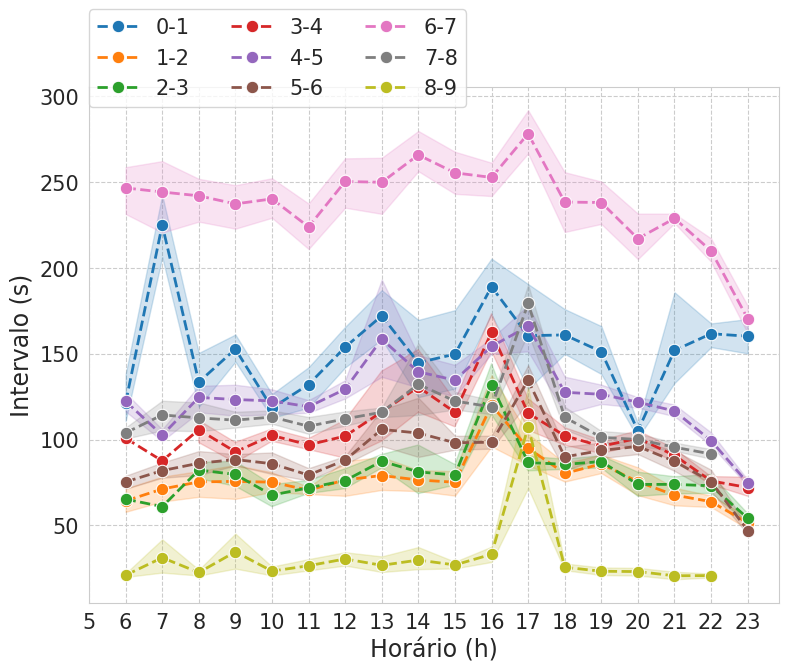

In [78]:
x = route_section.query("line_code == '829'").copy()
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = x.hour, y = x.delta_t_mean, estimator='mean', errorbar = ('ci', 95), marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = x.route_section, hue_order = x.sort_values('seq').route_section.drop_duplicates(), palette = sns.color_palette("tab10", x.route_section.nunique()), ax = axes)
g.set_xticks(range(5, 24))
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Horário (h)", fontsize = 17)
g.set_ylabel("Intervalo (s)", fontsize = 17)
plt.savefig('time_weight.png', format='png', dpi=300);

In [3]:
events.head()

,line_code,line_name,vehicle,latitude,longitude,name,legacy_id,type,seq,itinerary_id,...,next_event_timestamp,next_seq,next_legacy_id,next_name,next_type,next_latitude,next_longitude,delta_t,delta_s,route_section
95761,010,INTERBAIRROS I (HORÁRIO),BB300,-25.413929,-49.279703,"R. Tapajós, 948- Bom Retiro",190176,Novo mobiliário,39,481,...,2022-07-28 06:19:20,40.0,120110.0,"R. Carlos Pioli, 471 - Bom Retiro",Novo mobiliário,-25.410517,-49.276479,79.0,498.763751,39-40
95759,010,INTERBAIRROS I (HORÁRIO),BB300,-25.410517,-49.276479,"R. Carlos Pioli, 471 - Bom Retiro",120110,Novo mobiliário,40,481,...,2022-07-28 06:20:12,41.0,120112.0,"R. Dep. Mário de Barros, 1681 - Centro Cívico",Novo mobiliário,-25.411726,-49.270902,52.0,576.069587,40-41
95910,010,INTERBAIRROS I (HORÁRIO),BB300,-25.411726,-49.270902,"R. Dep. Mário de Barros, 1681 - Centro Cívico",120112,Novo mobiliário,41,481,...,2022-07-28 06:21:10,42.0,120111.0,"R. Jacy Loureiro de Campos, 1 - Centro Cívico",Novo mobiliário,-25.415285,-49.270134,58.0,403.240817,41-42
95716,010,INTERBAIRROS I (HORÁRIO),BB300,-25.415285,-49.270134,"R. Jacy Loureiro de Campos, 1 - Centro Cívico",120111,Novo mobiliário,42,481,...,2022-07-28 06:21:35,0.0,121012.0,"R. Ernâni Santiago de Oliveira, 212 - Centro C...",Novo mobiliário,-25.416483,-49.268804,25.0,188.641865,42-0
95618,010,INTERBAIRROS I (HORÁRIO),BB300,-25.416483,-49.268804,"R. Ernâni Santiago de Oliveira, 212 - Centro C...",121012,Novo mobiliário,0,481,...,2022-07-28 06:24:22,1.0,120113.0,"R. Prefeito Rosalvo G Mello Leitão, 101 - Cent...",Novo mobiliário,-25.414184,-49.265917,167.0,386.622914,0-1
